In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

Load data - from raw version

torch.float32 torch.Size([36, 3, 49, 49])
torch.float32 torch.Size([36, 1])
torch.float32 torch.Size([36, 1])
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])


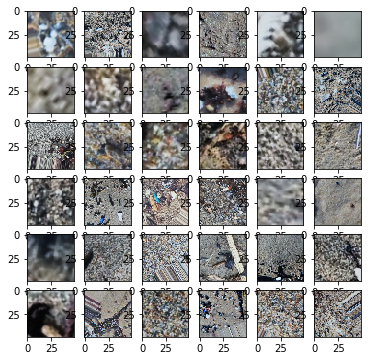

In [2]:
class RawDataset(Dataset):
    def __init__(self):
        s = 49
        self.imgin = np.fromfile("images/data_in.raw", dtype=np.uint8)
        self.imgin = self.imgin.reshape((len(self.imgin)//(3*s*s), 3, s, s))
        self.imgout = np.fromfile("images/data_out.raw", dtype=np.uint8)
        self.imgweight = np.fromfile("images/data_weight.raw", dtype=np.float32)
        self.imgweight = self.imgweight ** 0.5
        self.imgmean = np.fromfile("images/data_mean.raw", dtype=np.float32)
        self.imginvstdev = np.fromfile("images/data_invstdev.raw", dtype=np.float32)
        self.imgmean = self.imgmean.reshape((len(self.imgin), 3))
        self.imginvstdev = self.imginvstdev.reshape((len(self.imgin), 3))
        self.size = s

    def __len__(self):
        nin = self.imgin.shape[0]
        nout = len(self.imgout)
        assert nin == nout
        return nin

    def __getitem__(self, i):
        img = self.imgin[i].astype(np.float32) / 255.0
        for _ in range(3):
            img[_] = (img[_]-self.imgmean[i,_])*self.imginvstdev[i,_]
        return [
            img,
            self.imgout[i:i+1].astype(np.float32) / 255.0,
            self.imgweight[i:i+1]
        ]

dataset = RawDataset()
for imgin, imgout, imgweight in DataLoader(
    dataset,
    batch_size=36,
    shuffle=True
):
    print(imgin.dtype, imgin.shape)
    print(imgout.dtype, imgout.shape)
    print(imgweight.dtype, imgweight.shape)
    n = int(imgin.shape[0]**0.5)

    imgout = imgout.reshape((n, n))
    print(imgout)

    imgin = np.einsum('acij->aijc', imgin.numpy())

    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        img = imgin[i]
        plt.imshow(1.0/(1.0+np.exp(-img)))

    plt.show()
    break

Model

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        n = 4
        model = [
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 33x33
            nn.Conv2d(3, n, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        for _ in range(10):
            model += [
                nn.Conv2d(n, n, 3, 1, 0, bias=False),
                nn.ZeroPad2d(-1),
                nn.BatchNorm2d(n),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        model += [
            # 3 x 5x5
            nn.Conv2d(n, 1, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            # 1 x 1x1
            nn.Sigmoid()
        ]
        self.main = nn.Sequential(*model)
    
    def forward(self, x):
        return self.main(x)

model = Model()
print(model)

Model(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (12): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(4, 4, kerne

Training

In [16]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005, betas=(0.9, 0.999))


lossFun = torch.nn.BCELoss
flatten = torch.nn.Flatten()

print("ADAM")
count = 0
for epoch in range(1, 5+1):
    print("Epoch", epoch)
    for nin, nout, nweight in dataloader:
        optimizer.zero_grad()
        output = flatten(model(nin))
        loss = lossFun(nweight)(output, nout)
        loss.backward()
        optimizer.step()
        count += 1
        if count % 200 == 0:
            print("Iteration {} - loss = {}".format(count, loss.item()))

ADAM
Epoch 1
Iteration 200 - loss = 0.024471115320920944
Iteration 400 - loss = 0.01747746393084526
Iteration 600 - loss = 0.056321728974580765
Iteration 800 - loss = 0.017455222085118294
Iteration 1000 - loss = 0.06711629778146744
Iteration 1200 - loss = 0.016629472374916077
Iteration 1400 - loss = 0.04491433873772621
Iteration 1600 - loss = 0.024656426161527634
Epoch 2
Iteration 1800 - loss = 0.11876141279935837
Iteration 2000 - loss = 0.027827229350805283
Iteration 2200 - loss = 0.08934817463159561
Iteration 2400 - loss = 0.02183266542851925
Iteration 2600 - loss = 0.09665880352258682
Iteration 2800 - loss = 0.012296780943870544
Iteration 3000 - loss = 0.03539767861366272
Iteration 3200 - loss = 0.039238132536411285
Epoch 3
Iteration 3400 - loss = 0.07045519351959229
Iteration 3600 - loss = 0.0711103156208992
Iteration 3800 - loss = 0.060754720121622086
Iteration 4000 - loss = 0.04339668154716492
Iteration 4200 - loss = 0.00931070651859045
Iteration 4400 - loss = 0.03873737156391144

Calculate running mean and variance

In [17]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True
))

for nin, nout, nweight in dataloader:
    with torch.no_grad():
        output = flatten(model(nin))
        loss = lossFun(nweight)(output, nout)
        print(loss)

tensor(0.0490)


Export

In [18]:
import os
os.system("rm weights/*")

param_i = 0
bn_i = 0
bns = []
for param in model.parameters():
    data = param.data
    shape = '_'.join(map(str, data.shape))
    if len(data.shape) == 1:
        name = "bn{:02d}{}".format(bn_i//2, bn_i%2)
        bns.append((name, data))
        bn_i += 1
        continue
    name = "w{:02d}_{}".format(param_i, shape)
    data.numpy().astype(np.float32).tofile("weights/"+name+".bin")
    param_i += 1

bn_i = 0
for layer in model.main:
    if layer.__class__.__name__ != "BatchNorm2d":
        continue
    layer.track_running_stats = False  # freeze
    mu = layer.running_mean
    var = layer.running_var
    name = "bn{:02d}2".format(bn_i)
    bns.append((name, mu))
    name = "bn{:02d}3".format(bn_i)
    bns.append((name, var))
    bn_i += 1

bns.sort()
for name, data in bns:
    s = '[' + ', '.join(map(str, data.numpy())) + ']'
    print(f"{name}: {s},")

bn000: [1.1608828, 0.5193138, 1.5457983],
bn001: [0.19250497, -1.1675857, -0.48617542],
bn002: [0.0026623716, 0.0035136275, 0.005710279],
bn003: [0.6569471, 0.6513417, 0.6413064],
bn010: [0.68058866, 1.1725298, 1.6231686, 1.2718937],
bn011: [-1.7547764, -0.019157877, 0.2571655, -0.71018356],
bn012: [0.90018153, 0.8533629, 0.16751373, -1.4298269],
bn013: [13.547844, 11.393061, 2.589074, 6.007362],
bn020: [1.0382253, 2.1491024, 0.69773203, 1.6140293],
bn021: [-0.951792, -0.8801961, -0.15649931, -0.87682533],
bn022: [3.0000405, 0.17789848, 0.37699324, 0.40306008],
bn023: [10.100466, 42.54792, 30.26375, 25.475025],
bn030: [1.4308738, 0.9530937, 1.043198, 1.3543205],
bn031: [-0.47458172, -2.0865145, 0.2596618, -0.44351366],
bn032: [0.5249733, 0.15357272, 0.5412792, 0.82075524],
bn033: [23.19905, 7.2561054, 8.020065, 7.693754],
bn040: [0.7867194, 0.7114454, 1.6980618, 0.96597296],
bn041: [-0.97520566, -2.1003215, -0.7547039, 1.3351743],
bn042: [-1.1157843, 1.7983435, 1.0044147, -5.8491125],
